In [2]:
import os
import numpy as np
from subprocess import *
import sys
import h5py
import matplotlib.pyplot as pl
import lightcone_LAEinterface_decreasingz_xlos as lc
import matplotlib as mpl
import compute_ps_updated 
import angular_correlation_function as acf
from astropy.cosmology import z_at_value
from astropy.cosmology import WMAP9 as cosmo
import time
import xi_2D
import xi_3D
import LAE_Cluster as LAEC
cmap2 = mpl.colors.ListedColormap(['k', 'yellow'])
cmap3 = mpl.colors.ListedColormap(['k', 'white'])
pl.rcParams["font.family"] = "Times New Roman"
pl.rcParams['ytick.labelsize']=24
pl.rcParams['xtick.labelsize']=24
%load_ext autoreload
%autoreload 2
%matplotlib inline
start = 0.0
stop = 1
number_of_lines = 12
cm_subsection = np.linspace(start, stop, number_of_lines) 
cmap = pl.cm.Paired
cmap = cmap.reversed(pl.cm.Paired)
colors = [ cmap(x) for x in cm_subsection ]

path = '/users/michael/Research/PowerSpectrumNotebook/Boxes/'
def find_foldername(boxes_path , redshift, OUTPUT_NUMBER,  mode = 'some type'):
    #call(["echo looking for a " + str(mode) + " box at redshift " + str(redshift) ], shell = False )
    filename_list = open(boxes_path +'/filename_list_'+ str(mode) +'_' + str(OUTPUT_NUMBER) , 'w')
    call(["ls " + boxes_path + "*" + str(OUTPUT_NUMBER)], stdout = filename_list, shell = True)
    filename_list.close()
    with open(boxes_path + '/filename_list_' + str(mode) + '_' + str(OUTPUT_NUMBER), 'r') as inF:
        for line in inF:
            if mode in line and str(float(redshift)) in line and str(OUTPUT_NUMBER) in line:
                return  line.replace("\n", '')
            
def load_binary_data(filename, dtype=np.float32): 

    f = open(filename, "rb")
    data = f.read() 
    f.close() 
    _data = np.fromstring(data, dtype) 
    if sys.byteorder == 'big':
        _data = _data.byteswap()
    return _data

def box_maker(location):
    arr = load_binary_data(str(location))
    arr.shape = (HII_DIM,HII_DIM,HII_DIM)
    return arr.reshape((HII_DIM,HII_DIM,HII_DIM), order = 'F')

#new way of loading stuff
#name = 'xH_nohalos_z009.00_nf0.753192_Fstar0.0500_starPL0.5000_Fesc0.1000_escPL-0.5000_Mturn5.00e+08_HIIfilter1_RHIImax30_150_225Mpc_1337'
#data1 = np.fromfile(name ,dtype=np.float32)
#xH_data = data1.reshape((DIM,DIM,DIM))





('delta', 0.238732414637843)
('kmax', 3.6275987284684357)
('delta', 0.238732414637843)
('Rmax', 212.13203435596427)
('delta', 0.477464829275686)
('Rmax', 259.8076211353316)


In [42]:
HII_DIM = 200
DIM = 800
L_box = 300
M_alpha_min = 1e10
N = 500
lya_min = 2.5e42
pixelsperslab = 25
T_neutral = 1
T_ionized = 1

#directory to get the ionization boxes (for lightcone and ionization fied and density field)
homo_io ='/Users/michael/Research/LAE_Clustering/Simulation_Boxes/MturnHaloes5e8_zeta25_MturnxHII5e8_beta1_fullEoR_Seed200_xLos_noHalos/'
homo_oi = '/Users/michael/Research/LAE_Clustering/Simulation_Boxes/MturnHaloes5e8_zeta25_MturnxHII5e8_beta-1_fullEoR_Seed200_xLos/'
halo_directory = '/Users/michael/Research/LAE_Clustering/Simulation_Boxes/MturnHaloes5e8_zeta25_MturnxHII5e8_beta1_fullEoR_Seed200_xLos/'

ionization_boxes = (homo_io, homo_oi)
density_boxes = '/Users/michael/Research/LAE_Clustering/Simulation_Boxes/MturnHaloes5e8_zeta25_MturnxHII5e8_beta1_fullEoR_Seed200_xLos/'


In [101]:
#make arrays for the density boxes of different models
#make redshift ranges, nboxes is 14 which corresponds to the nboxes required for first z_start
#as we loop through lesser redshift ranges, we decrement nboxes by 1. So set nboxes to be the nboxes for z_starts[0]

#if we wanted to expand this to multiple fdutys, then we need only modify 
#density_z_beta = np.zeros((len(z_starts), len(betas))) -> np.zeros((len(z_starts), len(betas), len(fdutys)))
#and in a later cell add an extra loop:
#for f in range(len(fdutys)):
# MichaelLAE_slabs_wParams =  MichaelLAE.apply_parameters((fdutys[f],1e10),  LAEpos = MichaelLAE_slabs[slab])

betas = (1, -1)
z_starts = np.linspace(8.6, 6.6, 11)
z_end = 6.0
nboxes = 14
density_z_beta = np.zeros((len(z_starts), len(betas)))



In [115]:
#load the Halo Box into an array
halopos_z = []
for i in range(len(z_starts)):
    box = 'halos_z'+str(np.round(z_starts[i],1))+'0_800_300Mpc_82600201'
    halopos = np.genfromtxt(halo_directory + box, dtype=None)
    halopos_z.append(halopos)
    
#turn it into an array
halopos_z = np.array(halopos_z)


In [113]:
#make lightcone for each redshift, beta and slice

ionization_lightcones_beta_z_Dictionary = np.zeros((len(z_starts) , len(betas)) , dtype = object)
density_lightcones_beta_z_Dictionary = np.zeros((len(z_starts) , len(betas)) , dtype = object)
lightcone_redshifts_beta_z_Dictionary = np.zeros((len(z_starts) , len(betas)) , dtype = object)


for z in range(len(z_starts)):
    print('Doing z ' + str(z_starts[z]))
    
    for b in range(len(betas)):
        print('doing beta ' + str(betas[b]) )
        
        #make the lightcone for each quantity
        lightcone_Dictionary = {}
        densitylightcone_Dictionary = {}
        
        #if we wanted to change this to be the entire box, then change pixelsperslab to HII_DIM
        #and change the density method to slab = False
        for i in range(pixelsperslab):
            box_slice = HII_DIM - i -1
            lightcone_Dictionary[int(box_slice)] , lightcone_redshifts = lc.lightcone(DIM = HII_DIM, z_start = z_starts[z], z_end = z_end, N = N, nboxes = nboxes - int(z), box_slice = int(box_slice), directory =  ionization_boxes[b] , sharp_cutoff = 20, return_redshifts = True)
            densitylightcone_Dictionary[int(box_slice)] = lc.lightcone(DIM = HII_DIM, z_start = z_starts[z], z_end = z_end, N = N, nboxes = nboxes - int(z), box_slice = int(box_slice), directory = density_boxes , marker = 'updated_smoothed_deltax' , sharp_cutoff = 20)
            
    
        ionization_lightcones_beta_z_Dictionary[z][b] = lightcone_Dictionary
        lightcone_redshifts_beta_z_Dictionary[z][b] = lightcone_redshifts
        density_lightcones_beta_z_Dictionary[z][b] = densitylightcone_Dictionary
        
    print('Done this redshift')
            


        

Doing z 8.6
doing beta 1
doing beta -1
Done this redshift
Doing z 8.4
doing beta 1
doing beta -1
Done this redshift
Doing z 8.2
doing beta 1
doing beta -1
Done this redshift
Doing z 8.0
doing beta 1
doing beta -1
Done this redshift
Doing z 7.8
doing beta 1
doing beta -1
Done this redshift
Doing z 7.6
doing beta 1
doing beta -1
Done this redshift
Doing z 7.3999999999999995
doing beta 1
doing beta -1
Done this redshift
Doing z 7.199999999999999
doing beta 1
doing beta -1
Done this redshift
Doing z 7.0
doing beta 1
doing beta -1
Done this redshift
Doing z 6.8
doing beta 1
doing beta -1
Done this redshift
Doing z 6.6
doing beta 1
doing beta -1
Done this redshift


In [116]:
#be careful here, make sure we aren't muting something within each class


#compute the density for each beta, and z and store within density_beta_z
#if we are using different parameters for each z or beta or looping across fdutys, then move this step INTO the loop

#we will only do one slab for now
slab = str(7)
for z in range(len(z_starts)):
    z_range = np.linspace(z_starts[z], z_end, nboxes -int(z))
    #the following doesn't care about the ionization field
    MichaelLAE = LAEC.LAE_Cluster(halopos_z[z], HII_DIM, DIM, L_box)
    MichaelLAE_slabs = MichaelLAE.sort_into_slabs(slabs = 8, pixelsperslab = pixelsperslab)
    MichaelLAE_slabs_wParams =  MichaelLAE.apply_parameters((1,1e10),  LAEpos = MichaelLAE_slabs[slab])
    
    for b in range(len(betas)):
        MichaelLAE_slabs_wParams_wEoR =  MichaelLAE.apply_reionization_slabs(ionization_lightcones_beta_z_Dictionary[z][b] , z_range, T_neutral, T_ionized, LAEpos = MichaelLAE_slabs_wParams, lightcone_redshifts = lightcone_redshifts_beta_z_Dictionary[z][b], density = density_lightcones_beta_z_Dictionary[z][b])
        density = MichaelLAE.density(LAEpos = MichaelLAE_slabs_wParams_wEoR, slab_density = True)
        density_z_beta[z][b] = density
        
        print('At z ' + str(z_starts[z]) + ' and beta ' + str(betas[b]) + ' the density is ' + str(density))
        
        



There are 935165 halos in this object
At z 8.6 and beta1 the density is 0.00287525925926
At z 8.6 and beta-1 the density is 4.62222222222e-05
There are 1096266 halos in this object
At z 8.4 and beta1 the density is 0.00356562962963
At z 8.4 and beta-1 the density is 8.53333333333e-05
There are 1280668 halos in this object
At z 8.2 and beta1 the density is 0.00435259259259
At z 8.2 and beta-1 the density is 0.000156148148148
There are 1490400 halos in this object
At z 8.0 and beta1 the density is 0.00529362962963
At z 8.0 and beta-1 the density is 0.000298962962963
There are 1727159 halos in this object
At z 7.8 and beta1 the density is 0.00638903703704
At z 7.8 and beta-1 the density is 0.000525925925926
There are 1995862 halos in this object
At z 7.6 and beta1 the density is 0.00775140740741
At z 7.6 and beta-1 the density is 0.000926222222222
There are 2298775 halos in this object
At z 7.3999999999999995 and beta1 the density is 0.00938577777778
At z 7.3999999999999995 and beta-1 the

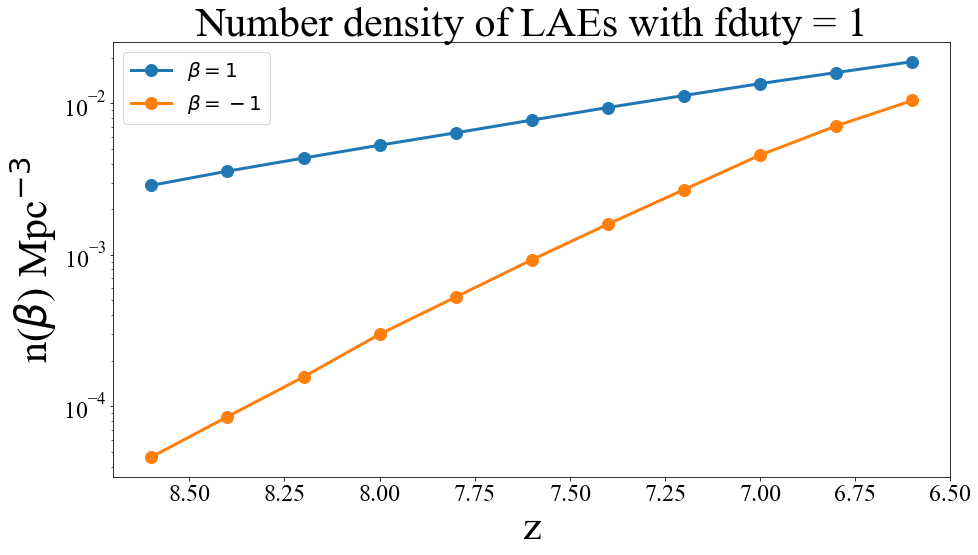

In [132]:
#plot

pl.figure(figsize = (15,8))
for b in range(len(betas)):
    pl.semilogy(np.round(z_starts,1), density_z_beta[:,b],  marker = 'o',markersize = 12, linewidth=3., label = r'$\beta = {}$' .format(betas[b]))

pl.title(r'Number density of LAEs with fduty = 1', fontsize = 42)
pl.legend(prop={'size': 20})
#pl.gca().invert_yaxis()
pl.gca().invert_xaxis()
pl.xlabel(r'z', fontsize = 42)
pl.ylabel(r'n($\beta$) Mpc$^{\rm{-3}}$',  fontsize = 42)
pl.xticks(fontsize=24)
pl.yticks(fontsize=24)
pl.show()
pl.close()
    
